# Set-Up

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

!pip install ko-ww-stopwords
!pip install kr-sentence
!python -m spacy download ko_core_news_md
!pip install konlpy

Mounted at /content/drive
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
2023-04-17 14:11:37.160443: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-04-17 14:11:37.218757: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-17 14:11:38.251097: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
Looking in indexes: https:

In [ ]:
from ko_ww_stopwords.stop_words import ko_ww_stop_words 
from ko_ww_stopwords.tools import is_stop_word, strip_outer_punct

print(ko_ww_stop_words)

{'우선', '이곳', '번', '어디', '향하여', '셋', '헉', '된다', '예하면', '언젠가', '뭐', '자기', '아홉', '만큼', '이때', '즉', '흥', '이까짓', '마터면', '그것들', '나', '이', '수', '일곱', '이쪽', '때', '저쪽', '허', '오로지', '듯이', '어떤것', '얼마', '자', '그까짓', '요컨대', '또', '잠시', '다섯', '통하여', '할뿐', '틈타', '어떤', '툭', '외에도', '스물', '겸', '정도로', '십', '함께', '무엇', '혼자', '어때', '저', '전자', '오히려', '전부', '차라리', '자신', '일', '어이', '하나', '대로', '그것', '이것', '혹시', '언제', '때문에', '제', '퉤', '됐다', '여기', '어느', '얼마만큼', '및', '칠', '그렇지만', '주라고', '저것', '여섯', '팔', '몇', '저까짓', '구', '참', '만일', '조금', '여부', '열', '달라고', '이런', '뭘', '어떠한', '위해서', '아무', '잠깐', '했다', '안', '한다', '삼', '거니까', '어떤것들', '응', '바로', '같이', '저런', '이상', '좀', '향해서', '어', '얼마나', '사', '여덟', '혼자서', '예컨대', '우리', '채로', '하나도', '훨씬', '이것들', '테니까', '따라', '육', '야', '즉시', '아직', '진짜로', '타인', '오자마자', '넷', '그', '오', '둘', '휴', '적이', '실로', '못', '왜', '그런', '왜냐하면', '저기', '제각기', '첫번째로'}


#Data & Pre-processing

In [ ]:
import pandas as pd

data = pd.read_table('/content/drive/MyDrive/korean-food-data/kr3.tsv')
data.head()

,Rating,Review
0,1,숙성 돼지고기 전문점입니다. 건물 모양 때문에 매장 모양도 좀 특이하지만 쾌적한 편...
1,1,고기가 정말 맛있었어요! 육즙이 가득 있어서 너무 좋았아요 일하시는 분들 너무 친절...
2,1,"잡내 없고 깔끔, 담백한 맛의 순댓국이 순댓국을 안 좋아하는 사람들에게도 술술 넘어..."
3,1,고기 양이 푸짐해서 특 순대국밥을 시킨 기분이 듭니다 맛도 좋습니다 다만 양념장이 ...
4,1,순댓국 자체는 제가 먹어본 순대국밥집 중에서 Top5 안에는 들어요. 그러나 밥 양...


In [ ]:
data.shape

(641762, 2)

I had to manually perform data pre-processing on the korean text. 

Since there are no "casings" in korean, I didn't have to lower() everything. 

I removed extra characters and white space. 

I did removed stop words in the korean language using the konlpy (Ko-NLP-py) library to tokenize the korean text, remove the stop words, and put the tokens back into a string. 

In [ ]:
import spacy
from konlpy.tag import Okt
from nltk.stem import WordNetLemmatizer
import re

# create a spacy nlp object
nlp = spacy.load("ko_core_news_md")

# create a WordNetLemmatizer object
lemmatizer = WordNetLemmatizer()

# create a list of stop words
stop_words = set(ko_ww_stop_words)

# define a function to preprocess text
def preprocess_text(text):
    # convert text to lowercase

    # remove non-alphanumeric characters and extra whitespaces
    # [^a-zA-Z\s] doesnt apply to korean
    # Remove special characters
    text = re.sub(r'[^\w\s]', '', text)
    # Remove excess whitespace
    text = re.sub(r'\s+', ' ', text)
    # apply spacy nlp to tokenize and lemmatize the text
    doc = nlp(text)

    # tokenize korean sentence
    okt = Okt()
    tokens = okt.morphs(text, stem=True)

    # filter out stop words
    filtered_tokens = [token for token in tokens if token not in stop_words]

    # join the tokens back into a string
    processed_text = ' '.join(tokens)
    return processed_text

I remove data with ambiguous reviews, so we are only left with positive and negative reviews. This still leaves us with 459,000 samples.

In [ ]:
# remove data with ambiguous reviews
data = data[data.Rating != 2]

In [ ]:
data.shape

(459021, 2)

Next, I can see that there are only 70,000 negative reviews, and 388,000 positive reviews. In order to balance out the dataset, I pick 25,000 positive samples, 25,000 negative samples, merge them, and shuffle the data. 

In [ ]:
equal_zero = data.loc[data['Rating'] == 0]
equal_zero_trunc = equal_zero.iloc[:2500]

In [ ]:
equal_one = data.loc[data['Rating'] == 1]
equal_one_trunc = equal_one.iloc[:2500]

In [ ]:
equal_zero_trunc.shape

(2500, 2)

In [ ]:
frames = [equal_zero_trunc, equal_one_trunc]

equal_unsorted = pd.concat(frames)

In [ ]:
equal_unsorted.shape

(5000, 2)

In [ ]:
equal_sorted = equal_unsorted.sample(frac=1).reset_index(drop=True)

In [ ]:
# apply the preprocess_text function to the text column of the dataframe
# took 15 minutes
equal_sorted['Review'] = equal_sorted['Review'].apply(preprocess_text)

In [ ]:
equal_sorted.to_csv('/content/drive/MyDrive/korean-food-data/equal-pre-processed_kr3_5k.csv', index=False)

Code below is the raw distribution, which has an overwhelming ratio of positive to negative reviews, which could skew the training

In [ ]:
# dataset = data.iloc[:50000]

In [ ]:
# dataset.to_csv('/content/drive/MyDrive/korean-food-data/kr3_50k.csv', index=False)

In [ ]:
# df = pd.read_csv('/content/drive/MyDrive/korean-food-data/kr3_50k.csv')

In [ ]:
# df.head()

In [ ]:
# apply the preprocess_text function to the text column of the dataframe
# took 15 minutes
# df['Review'] = df['Review'].apply(preprocess_text)

References: 

sentence tokenizer: https://github.com/Rairye/kr-sentence

spacy korean Korean language support: https://spacy.io/usage/models

spacy korean pretrained model: https://spacy.io/models/ko

korean regex: https://stackoverflow.com/questions/38156300/regex-how-do-you-match-korean-hangul-letters-in-javascript-es6

In [ ]:
# df.to_csv('/content/drive/MyDrive/korean-food-data/pre-processed_kr3_50k.csv', index=False)

In [ ]:
df2 = pd.read_csv('/content/drive/MyDrive/korean-food-data/pre-processed_kr3_50k.csv')
df2.head()

,Rating,Review
0,1,숙성 돼지고기 전문점입니다. 건물 모양 때문에 매장 모양도 좀 특이하지만 쾌적한 편...
1,1,고기가 정말 맛있었어요! 육즙이 가득 있어서 너무 좋았아요 일하시는 분들 너무 친절...
2,1,"잡내 없고 깔끔, 담백한 맛의 순댓국이 순댓국을 안 좋아하는 사람들에게도 술술 넘어..."
3,1,고기 양이 푸짐해서 특 순대국밥을 시킨 기분이 듭니다 맛도 좋습니다 다만 양념장이 ...
4,1,순댓국 자체는 제가 먹어본 순대국밥집 중에서 Top5 안에는 들어요. 그러나 밥 양...


In [ ]:
X = df2.Review
y = df2.Rating

In [ ]:
X.head()

0    숙성 돼지고기 전문점입니다. 건물 모양 때문에 매장 모양도 좀 특이하지만 쾌적한 편...
1    고기가 정말 맛있었어요! 육즙이 가득 있어서 너무 좋았아요 일하시는 분들 너무 친절...
2    잡내 없고 깔끔, 담백한 맛의 순댓국이 순댓국을 안 좋아하는 사람들에게도 술술 넘어...
3    고기 양이 푸짐해서 특 순대국밥을 시킨 기분이 듭니다 맛도 좋습니다 다만 양념장이 ...
4    순댓국 자체는 제가 먹어본 순대국밥집 중에서 Top5 안에는 들어요. 그러나 밥 양...
Name: Review, dtype: object

In [ ]:
y[:10]

0    1
1    1
2    1
3    1
4    1
5    1
6    1
7    1
8    1
9    1
Name: Rating, dtype: int64

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y,stratify=y, test_size=0.2, train_size=0.8,random_state=1234)

X_train.shape

(40000,)

Text(0, 0.5, 'Count')

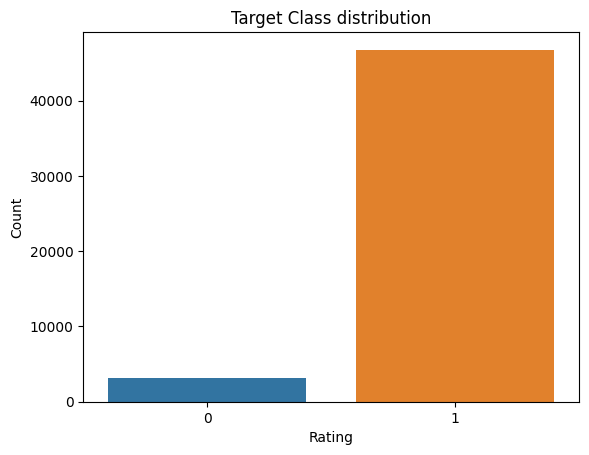

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# count the number of occurrences of each string in the DataFrame
counts = df2['Rating'].value_counts()

# create a bar plot of the counts using seaborn
sns.barplot(x=counts.index, y=counts.values)

# add a title and labels to the plot
plt.title('Target Class distribution')
plt.xlabel('Rating')
plt.ylabel('Count')

Text(0, 0.5, 'Count')

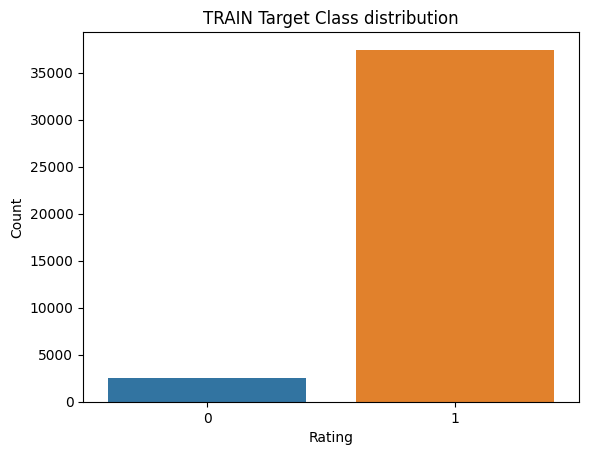

In [ ]:
train_counts = y_train.value_counts()
# create a bar plot of the counts using seaborn
sns.barplot(x=train_counts.index, y=train_counts.values)

# add a title and labels to the plot
plt.title('TRAIN Target Class distribution')
plt.xlabel('Rating')
plt.ylabel('Count')

Text(0, 0.5, 'Count')

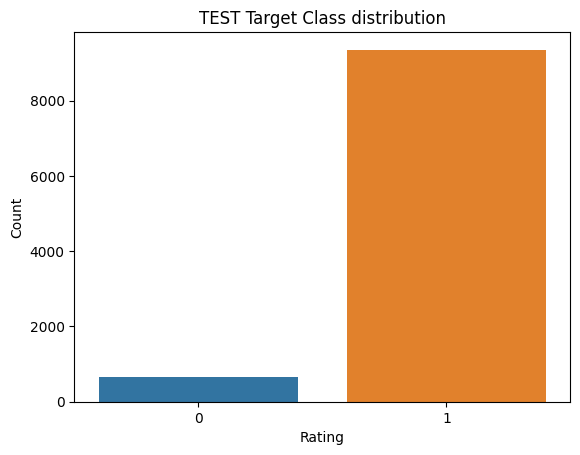

In [ ]:
test_counts = y_test.value_counts()
# create a bar plot of the counts using seaborn
sns.barplot(x=test_counts.index, y=test_counts.values)

# add a title and labels to the plot
plt.title('TEST Target Class distribution')
plt.xlabel('Rating')
plt.ylabel('Count')

## Describe the data set and what the model should be able to predict:

The dataset has 2 columns, a column containing restaurant reviews in Korean and a column containing the corresponding Rating of the restaurant (0 = negative, 1 = positive). Once trained, a model should be able to take in a review of a restaurant in korean, and predict weather the reviewer liked or disliked the restaurant.